In [1]:
# 清除内存，预防报错
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import tensorflow as tf
import gc
 
# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()
 
    try:
        del classifier # this is from global space - change this as you need
    except:
        pass
 
    print(gc.collect()) # if it does something you should see a number as output
 
    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))


In [2]:
train_root = r'D:\Program Files (x86)\pythonProject\python文件\南洋理工\new622\train'
test_root = r'D:\Program Files (x86)\pythonProject\python文件\南洋理工\new622\test'
val_root = r'D:\Program Files (x86)\pythonProject\python文件\南洋理工\new622\val'

In [3]:
# 参数初始化
dim = (224,224)                            

In [4]:
from skimage import io
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, LeakyReLU,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard
import pickle
from PIL import Image
import time
import os
from PIL import Image
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from keras import regularizers

In [5]:
from sklearn.metrics import accuracy_score, average_precision_score,precision_score,f1_score,recall_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau
import math

earlyStopping = EarlyStopping(
    monitor='val_accuracy', patience=8, verbose=1, mode='max', restore_best_weights=True)

reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                           patience=5, verbose=1, mode='max', cooldown=1, min_lr=1e-8)

callback_list = [earlyStopping, reduce]

#设置回调函数用于后续训练

In [6]:
#设置优化器
# opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=True,name='SGD') 
adam=tf.keras.optimizers.Adam(learning_rate=0.001)

In [7]:
def get_result_2(model_history,vg_model,test_data):
    #     train_scores = vg_model.evaluate(train_data, train_labels)
#     val_scores = vg_model.evaluate(val_data,val_labels)
    test_scores = vg_model.evaluate(test_data)

#     print('Train Accuracy: %.2f%%'%(train_scores[1]*100))
#     print('Validation Accuracy: %.2f%%'%(val_scores[1]*100))
    print('Test Accuracy: %.2f%%'%(test_scores[1]*100))
    
    fig, ax = plt.subplots(1, 3, figsize = (30, 5))
    ax = ax.ravel()

    for i, metric in enumerate(["accuracy", "loss"]):
        ax[i].plot(model_history.history[metric])
        ax[i].plot(model_history.history["val_" + metric])
        ax[i].set_title("Model {}".format(metric))
        ax[i].set_xlabel("Epochs")
        ax[i].set_ylabel(metric)
        ax[i].legend(["train", "val"])
        
    pred = vg_model.predict(test_data)
    pred=np.argmax(pred,axis=1)
    
    # TTA_WAY

    cm = confusion_matrix(y_true= test_data.classes,y_pred=pred,labels=[0,1,2,3])

    # sns.heatmap(cm,annot = True)
    plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    ax = sn.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels= ['Mild', 'Moderate', 'Normal', 'VeryMild'],
            yticklabels=['Mild', 'Moderate', 'Normal', 'VeryMild'])
    plt.title('Alzheimer\'s Diagnosis')
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    # plt.subplots(figsize=(9, 6))
    plt.show(ax)
    print('------Weighted------')
    print('Weighted precision', precision_score(test_data.classes, pred, average='weighted'))
    print('Weighted recall', recall_score(test_data.classes, pred, average='weighted'))
    print('Weighted f1-score', f1_score(test_data.classes, pred, average='weighted'))
    print('------Macro------')
    print('Macro precision', precision_score(test_data.classes, pred, average='macro'))
    print('Macro recall', recall_score(test_data.classes, pred, average='macro'))
    print('Macro f1-score', f1_score(test_data.classes, pred, average='macro'))
    print('------Micro------')
    print('Micro precision', precision_score(test_data.classes, pred, average='micro'))
    print('Micro recall', recall_score(test_data.classes, pred, average='micro'))
    print('Micro f1-score', f1_score(test_data.classes, pred, average='micro'))
    
#     tta_steps = 10

#     predictions = []
    
#     for i in range(tta_steps):
#     #     preds = model.predict_generator(test_datagen.flow(test_data, batch_size=batch_size, shuffle=False), steps = len(test_data)/batch_size)
#         preds = model.predict(test_data_TTA,verbose=0)
#         predictions.append(preds)

#     final_pred = np.mean(predictions, axis=0)
#     pred = np.argmax(final_pred, axis=-1)
#     true = test_data.classes
    
#     print('------TTA_SCORE------')
#     print(f'Accuracy with TTA: {np.mean(np.equal(pred,true))}')
    


In [14]:
incep_model = tf.keras.applications.inception_v3.InceptionV3(weights=None,
    classes=4) 

incep_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_99 (Conv2D)             (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_96 (BatchN  (None, 149, 149, 32  96         ['conv2d_99[0][0]']              
 ormalization)                  )                                                      

 batch_normalization_101 (Batch  (None, 35, 35, 64)  192         ['conv2d_104[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_103 (Batch  (None, 35, 35, 64)  192         ['conv2d_106[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_106 (Batch  (None, 35, 35, 96)  288         ['conv2d_109[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_107 (Batch  (None, 35, 35, 32)  96          ['conv2d_110[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_118 (Batch  (None, 35, 35, 64)  192         ['conv2d_121[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_116 (Activation)    (None, 35, 35, 64)   0           ['batch_normalization_118[0][0]']
                                                                                                  
 conv2d_119 (Conv2D)            (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_122 (Conv2D)            (None, 35, 35, 96)   55296       ['activation_116[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_9 (MaxPooling2D)  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_120[0][0]',         
                                                                  'activation_123[0][0]',         
                                                                  'max_pooling2d_9[0][0]']        
                                                                                                  
 conv2d_133 (Conv2D)            (None, 17, 17, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_130 (Batch  (None, 17, 17, 128)  384        ['conv2d_133[0][0]']             
 Normaliza

                                                                  'activation_133[0][0]']         
                                                                                                  
 conv2d_143 (Conv2D)            (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_140 (Batch  (None, 17, 17, 160)  480        ['conv2d_143[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_138 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_140[0][0]']
                                                                                                  
 conv2d_144 (Conv2D)            (None, 17, 17, 160)  179200      ['activation_138[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_148 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_150[0][0]']
                                                                                                  
 conv2d_154 (Conv2D)            (None, 17, 17, 160)  179200      ['activation_148[0][0]']         
                                                                                                  
 batch_normalization_151 (Batch  (None, 17, 17, 160)  480        ['conv2d_154[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_149 (Activation)    (None, 17, 17, 160)  0           ['batch_normalization_151[0][0]']
          

                                                                                                  
 batch_normalization_161 (Batch  (None, 17, 17, 192)  576        ['conv2d_164[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_159 (Activation)    (None, 17, 17, 192)  0           ['batch_normalization_161[0][0]']
                                                                                                  
 conv2d_160 (Conv2D)            (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_165 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_159[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_169 (Conv2D)            (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_173 (Conv2D)            (None, 17, 17, 192)  258048      ['activation_167[0][0]']         
                                                                                                  
 batch_normalization_166 (Batch  (None, 17, 17, 192)  576        ['conv2d_169[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_170 (Batch  (None, 17, 17, 192)  576        ['conv2d_173[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 batch_normalization_172 (Batch  (None, 8, 8, 320)   960         ['conv2d_175[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_172 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_174[0][0]']
                                                                                                  
 activation_173 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_175[0][0]']
                                                                                                  
 activation_176 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_178[0][0]']
                                                                                                  
 activatio

 activation_182 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_184[0][0]']
                                                                                                  
 activation_185 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_187[0][0]']
                                                                                                  
 activation_186 (Activation)    (None, 8, 8, 384)    0           ['batch_normalization_188[0][0]']
                                                                                                  
 batch_normalization_189 (Batch  (None, 8, 8, 192)   576         ['conv2d_192[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_179 (Activation)    (None, 8, 8, 320)    0           ['batch_normalization_181[0][0]']
          

In [15]:
incep_model.compile(optimizer=adam, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [10]:
#生成数据
zoom = [.99,1.01]             
bright_range = [.8,1.2]                               
momentum = .9   

Generator = ImageDataGenerator( rescale=1./255,
                                    fill_mode='constant',
                                    cval=0,
                                    brightness_range=bright_range,
                                    zoom_range=zoom,
                                    data_format='channels_last',
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    validation_split = 0.2,
                                    zca_whitening=False)

    # train_data_gen = train_dr.flow_from_directory(directory=train_root,target_size=,
    #                                               batch_size=5000)

batch_size =15

train_data  = Generator.flow_from_directory(directory = train_root,
                                            target_size = dim,
                                            class_mode = 'categorical',#独热标签

                                            batch_size = batch_size)


valid_data = Generator.flow_from_directory(directory = val_root,
                                                  target_size = dim,
                                                  class_mode = 'categorical',

                                                  batch_size = batch_size)


# Change to zoom = [1,1] to use normal test data
test_Generator = ImageDataGenerator(rescale=1./255,
                                    fill_mode='constant',
                                    cval=0,
                                    zoom_range=[1,1],
                                    data_format='channels_last') 

test_data = test_Generator.flow_from_directory(directory=test_root,
                                        target_size=dim,
                                        batch_size = batch_size,
                                        shuffle = False) # test data should not be shuffled to keep labels

Found 6852 images belonging to 4 classes.
Found 2283 images belonging to 4 classes.
Found 2289 images belonging to 4 classes.


In [16]:
#训练模型
model_history = incep_model.fit(train_data,validation_data=valid_data,
                          batch_size = 20,
                          callbacks= callback_list,
                          epochs=100, shuffle=True) 


Epoch 1/100
457/457 [==============================] - 139s 279ms/step - loss: 1.0108 - accuracy: 0.5209 - val_loss: 1.2805 - val_accuracy: 0.4985 - lr: 1.0000e-04
Epoch 2/100
457/457 [==============================] - 128s 280ms/step - loss: 0.9201 - accuracy: 0.5539 - val_loss: 1.0654 - val_accuracy: 0.5353 - lr: 1.0000e-04
Epoch 3/100
457/457 [==============================] - 126s 276ms/step - loss: 0.8978 - accuracy: 0.5658 - val_loss: 0.8866 - val_accuracy: 0.5782 - lr: 1.0000e-04
Epoch 4/100
457/457 [==============================] - 129s 282ms/step - loss: 0.8643 - accuracy: 0.5757 - val_loss: 0.9395 - val_accuracy: 0.5466 - lr: 1.0000e-04
Epoch 5/100
457/457 [==============================] - 127s 278ms/step - loss: 0.8255 - accuracy: 0.5976 - val_loss: 0.9090 - val_accuracy: 0.5940 - lr: 1.0000e-04
Epoch 6/100
457/457 [==============================] - 129s 281ms/step - loss: 0.7910 - accuracy: 0.6283 - val_loss: 0.8157 - val_accuracy: 0.5966 - lr: 1.0000e-04
Epoch 7/100
457/

457/457 [==============================] - 130s 283ms/step - loss: 0.0022 - accuracy: 0.9996 - val_loss: 0.0705 - val_accuracy: 0.9777 - lr: 1.0000e-06
Epoch 49/100
457/457 [==============================] - 131s 286ms/step - loss: 0.0016 - accuracy: 0.9994 - val_loss: 0.0893 - val_accuracy: 0.9733 - lr: 1.0000e-07
Epoch 50/100
457/457 [==============================] - 130s 285ms/step - loss: 0.0024 - accuracy: 0.9991 - val_loss: 0.0805 - val_accuracy: 0.9755 - lr: 1.0000e-07
Epoch 51/100
457/457 [==============================] - 131s 286ms/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.0707 - val_accuracy: 0.9772 - lr: 1.0000e-07
Epoch 51: early stopping


153/153 [==============================] - 11s 73ms/step - loss: 0.0880 - accuracy: 0.9751
Test Accuracy: 97.51%
153/153 [==============================] - 11s 60ms/step


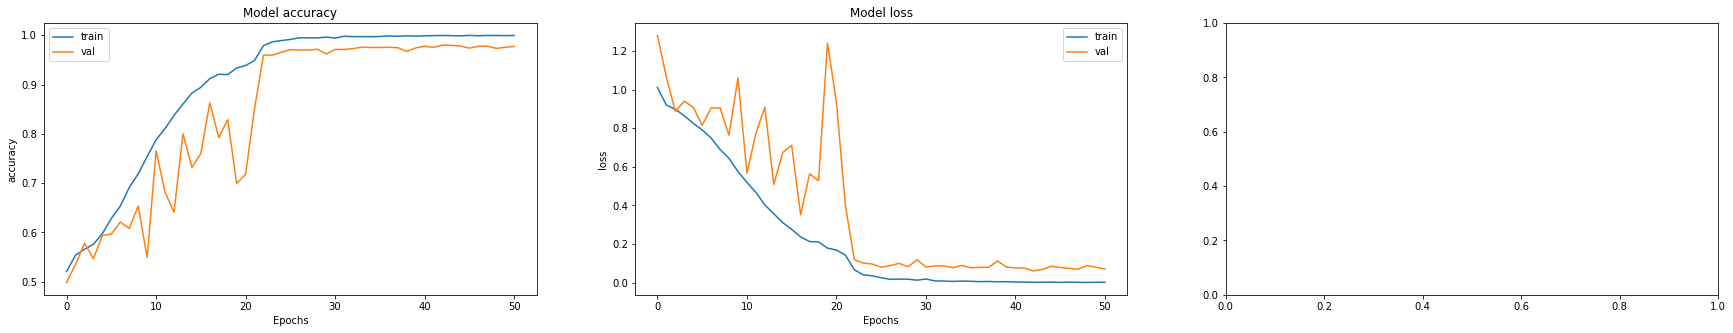

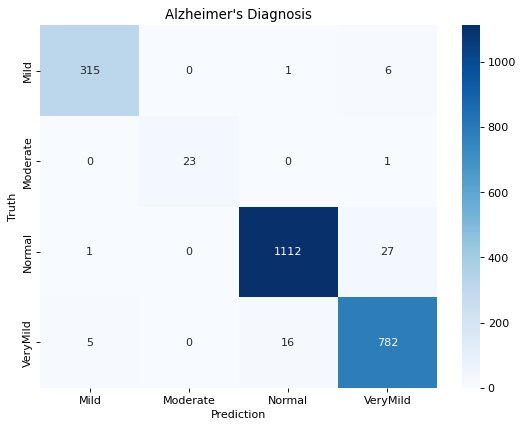

------Weighted------
Weighted precision 0.9752544088134876
Weighted recall 0.9750982961992136
Weighted f1-score 0.9751380468615772
------Macro------
Macro precision 0.9811460428686926
Macro recall 0.9714702172820648
Macro f1-score 0.9761753905301653
------Micro------
Micro precision 0.9750982961992136
Micro recall 0.9750982961992136
Micro f1-score 0.9750982961992136


In [17]:
get_result_2(model_history,incep_model,test_data)